# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [1]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

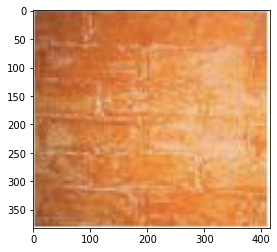

In [3]:
sample_img_dir = 'image/back2.jpeg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = sample_img.astype(np.float32)/255.0
    plt.imshow(sample_img[...,-1::-1])

In [4]:
sample_img.shape

(382, 416, 3)

In [5]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    output = np.zeros((out_size,out_size,3), dtype=np.float32)
    number = out_size // patch_size
    # plt.imshow(patch_selected)
    for i in range (number):
        for j in range (number):
            a = random.randint(0,sample.shape[0]-patch_size)
            patch_selected = sample[a:a+patch_size,a:a+patch_size]
            output[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size] = patch_selected
    # ball = img[20:30,30:30]
    # img[30:40,30:30] = ball
    return output
# ssd = (np.sum((mask*template)**2)) - 2 * cv2.filter2D(sample, cv2.CV_64F, mask*template) + cv2.filter2D((np.ones(sample.shape)*sample)**2,cv2.CV_64F, mask)

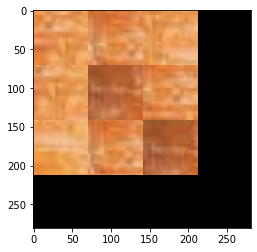

In [6]:
out_size = 281  # feel free to change to debug
patch_size = 71 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
plt.imshow(res[...,-1::-1])

### Part II: Overlapping Patches (30 pts)

In [7]:
import math
# Suppose I have a template T, a mask M, and an image I: then, 
# ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
def ssd_patch(sample, patch_size, template, mask):
    """
    ssd_patch performs template matching with the overlapping region, computing the cost of sampling 
    each patch, based on the sum of squared differences (SSD) of the overlapping regions of the existing 
    and sampled patch.
    """
    start_index = (patch_size-1) // 2 
    end_index = (sample.shape[0]-1) - start_index # end index is 191-9=182, take care !!!!!!!!
#     print("template")
#     plt.imshow(template)
#     plt.show()
#     print("mask")
#     plt.imshow(mask)
#     plt.show()
#     print("sample")
#     plt.imshow(sample)
#     plt.show()
    ssd = ((mask*template)**2).sum() - 2 * cv2.filter2D(sample, ddepth=-1, kernel = mask*template) + cv2.filter2D(sample ** 2, ddepth=-1, kernel=mask)
#     plt.imshow(ssd.mean(2)) !!!!!!!!!!!
#     plt.show()
    sample_size = sample.shape[0]
    cost_image = np.zeros((sample_size,sample_size), dtype=np.float32) 
    for i in range(start_index,end_index+1):
        for j in range(start_index,end_index+1):
            cost_image[i,j] = ssd[i,j].sum()
#     print("cost image")
#     print(cost_image)
#     plt.imshow(cost_image)
#     plt.show()
    return cost_image

In [8]:
def choose_sample(sample, patch_size, cost_image, tol):
    # for sample.shape = (192,192,3) and patch_size = 19 and overlap = 5
    start_index = (patch_size-1) // 2 # start index is (19-1)/2=9
    end_index = (sample.shape[0]-1) - start_index  # end index is 191-9=182, take care !!!!!!!!
    minc = float("inf")
    # first to find the min cost 
    for i in range (start_index,end_index+1):
        for j in range (start_index,end_index+1):
            if cost_image[i,j] < minc:
                minc = cost_image[i,j]
    compare_cost = minc*(1+tol)
    for i in range (start_index,end_index+1):
        for j in range (start_index,end_index+1):
            if cost_image[i,j] < compare_cost:
                return i,j

In [9]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    output = np.zeros((out_size,out_size,3), dtype=np.float32)
    patch_size_remained = patch_size - overlap
    number = (out_size - patch_size) // patch_size_remained + 1 # the number of patches in one row
    # Start by sampling a random patch for the upper-left corner. 
    k = (patch_size-1) // 2
    a = random.randint(0,sample.shape[0]-patch_size)
    b = random.randint(0,sample.shape[0]-patch_size)
#     a = 0
#     b = 0
    output[0:patch_size,0:patch_size] = sample[a:a+patch_size,b:b+patch_size]
    print(a,b)
    # the second patch along the top row will overlap by patch_size 
    # pixels in the vertical direction and overlap pixels in the horizontal direction.
    for h_left_index in range (0,number):
        for w_left_index in range (0,number):
            # The mask has the same size as the patch template and 
            # has values of 1 in the overlapping region and values of 0 elsewhere.
            mask = np.zeros((patch_size,patch_size,3), dtype=np.float32)
            # the coordinate of the left_top point is (x_left_top*patch_size_remained, y_left_top*patch_size_remained)
            if (w_left_index == 0) and (h_left_index == 0):
                mask[:,0:overlap] = 1.0
                mask[0:overlap,:] = 1.0
                continue
            elif (h_left_index == 0):
                mask[:,0:overlap] = 1.0
            elif (w_left_index == 0):
                mask[0:overlap,:] = 1.0
            else:
                mask[:,0:overlap] = 1.0
                mask[0:overlap,:] = 1.0
            h_left = h_left_index * patch_size_remained
            w_left = w_left_index * patch_size_remained
            #  The template is the patch in the current output image that is to be filled in 
            # (many pixel values will be 0 because they are not filled in yet). 
            template = output[h_left:h_left+patch_size,w_left:w_left+patch_size]
#             plt.imshow(mask)
#             plt.show()
#             print(mask)
            cost_image = ssd_patch(sample, patch_size, template, mask)
            i ,j = choose_sample(sample, patch_size, cost_image, tol)
            output[h_left:h_left+patch_size,w_left:w_left+patch_size] = sample[i-k:i+k+1, j-k:j+k+1] 
            # the same as the patch_size
    return output

58 4


Text(0.5, 1.0, 'quilt_simple')

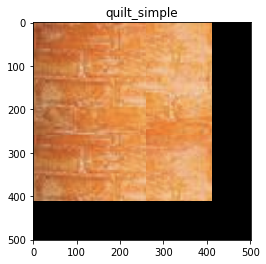

In [10]:
res = quilt_simple(sample_img, 501, 151, 21, 0.0000001) #feel free to change parameters to get best results
plt.imshow(res[...,-1::-1]) # overlap 0.005 is not enough while 0.0005 is enough
plt.title('quilt_simple')

In [11]:
#     plt.figure()
#     plt.imshow(im1_lowpass, cmap='gray')
#     plt.axis('off')
#     plt.savefig('./image/dog_filter_low.jpg')

### Part III: Seam Finding (20 pts)


In [12]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [13]:
def calculate_err(overlap_origin,overlap_sample):
    h = overlap_origin.shape[0]
    w = overlap_origin.shape[1]
    overlap_diff = overlap_origin - overlap_sample 
    overlap_diff = np.square(overlap_diff)
    err_patch = np.zeros((h,w),dtype=np.float32)
    for i in range (h):
        for j in range (w):
            err_patch[i,j] = overlap_diff[i][j].sum()
    return err_patch

In [14]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    output = np.zeros((out_size,out_size,3), dtype=np.float32)
    patch_size_remained = patch_size - overlap
    number = (out_size - patch_size) // patch_size_remained + 1 # the number of patches in one row
    # Start by sampling a random patch for the upper-left corner. 
    k = (patch_size-1) // 2
    a = random.randint(0,sample.shape[0]-patch_size)
    b = random.randint(0,sample.shape[0]-patch_size)
#     a = 0
#     b = 0
    output[0:patch_size,0:patch_size] = sample[a:a+patch_size,b:b+patch_size]
    print(a,b)
    # the second patch along the top row will overlap by patch_size 
    # pixels in the vertical direction and overlap pixels in the horizontal direction.
    for h_left_index in range (0,number):
        for w_left_index in range (0,number):
            # The mask has the same size as the patch template and 
            # has values of 1 in the overlapping region and values of 0 elsewhere.
            mask = np.zeros((patch_size,patch_size,3), dtype=np.float32)
            # the coordinate of the left_top point is (x_left_top*patch_size_remained, y_left_top*patch_size_remained)
            if (w_left_index == 0) and (h_left_index == 0):
                mask[:,0:overlap] = 1.0
                mask[0:overlap,:] = 1.0
                continue
            elif (h_left_index == 0):
                mask[:,0:overlap] = 1.0
            elif (w_left_index == 0):
                mask[0:overlap,:] = 1.0
            else:
                mask[:,0:overlap] = 1.0
                mask[0:overlap,:] = 1.0
            h_left = h_left_index * patch_size_remained
            w_left = w_left_index * patch_size_remained
            #  The template is the patch in the current output image that is to be filled in 
            # (many pixel values will be 0 because they are not filled in yet). 
            template = output[h_left:h_left+patch_size,w_left:w_left+patch_size]
            cost_image = ssd_patch(sample, patch_size, template, mask)
            i ,j = choose_sample(sample, patch_size, cost_image, tol)
            # output[h_left:h_left+patch_size,w_left:w_left+patch_size] = sample[i-k:i+k+1, j-k:j+k+1] 
            # the same as the patch_size
            # added code for quilt_cost -----------------------------------------------------------
            # the situdation of left overlaps
            if (h_left_index == 0): 
                overlap_origin = output[h_left:h_left+patch_size,w_left:w_left+overlap] 
                overlap_sample = sample[i-k:i-k+patch_size, j-k:j-k+overlap]
                
                err_patch = calculate_err(overlap_origin,overlap_sample)
                mask = cut(err_patch.T)
                mask = mask.T
                h,w = mask.shape
                mask_handle = np.zeros((h,w,3), dtype = np.float32)
                # convert int to float, can't find easier way
                for a in range(h):
                    for b in range(w):
                        if mask[a,b] == 1:
                            for c in range(3):
                                mask_handle[a,b,c] = 1.0
                        else:
                            for c in range(3):
                                mask_handle[a,b,c] = 0.0
                overlap_mix = overlap_origin*(1-mask_handle) + overlap_sample*mask_handle
                output[h_left:h_left+patch_size,w_left:w_left+patch_size] = sample[i-k:i+k+1, j-k:j+k+1] 
                output[h_left:h_left+patch_size,w_left:w_left+overlap] = overlap_mix
            # the situdation of top overlaps
            elif (w_left_index == 0): 
                overlap_origin = output[h_left:h_left+overlap,w_left:w_left+patch_size] 
#                 plt.imshow(overlap_origin[...,-1::-1])
#                 plt.show()
                overlap_sample = sample[i-k:i-k+overlap, j-k:j-k+patch_size]
#                 plt.imshow(overlap_sample[...,-1::-1])
#                 plt.show()
                err_patch = calculate_err(overlap_origin,overlap_sample)
#                 print("cost")
#                 plt.imshow(err_patch[...,-1::-1])
#                 plt.show()
                
                
                mask = cut(err_patch)
                h,w = mask.shape
                mask_handle = np.zeros((h,w,3), dtype = np.float32)
                # convert int to float, cannot find easier way
                for a in range(h):
                    for b in range(w):
                        if mask[a,b] == 1:
                            for c in range(3):
                                mask_handle[a,b,c] = 1.0
                        else:
                            for c in range(3):
                                mask_handle[a,b,c] = 0.0
#                 temp1 = overlap_origin*(1-mask_handle)
#                 plt.imshow(temp1[...,-1::-1])
#                 plt.show()
#                 temp2 = overlap_sample*mask_handle
#                 plt.imshow(temp2[...,-1::-1])
#                 plt.show()
                overlap_mix = overlap_origin*(1-mask_handle) + overlap_sample*mask_handle
#                 plt.imshow(overlap_mix[...,-1::-1])
#                 plt.show()
                output[h_left:h_left+patch_size,w_left:w_left+patch_size] = sample[i-k:i+k+1, j-k:j+k+1] 
                output[h_left:h_left+overlap,w_left:w_left+patch_size] = overlap_mix
            # if a patch has top and left overlaps, you will need to compute two seams, 
            # and the mask can be defined as the intersection of the masks for each seam (mask1&mask2)
            else:
                # left overlaps part
                overlap_origin = output[h_left:h_left+patch_size,w_left:w_left+overlap] 
                overlap_sample = sample[i-k:i-k+patch_size, j-k:j-k+overlap]
               
                err_patch = calculate_err(overlap_origin,overlap_sample)
                mask3 = cut(err_patch.T)
                mask3 = mask3.T

                h,w = mask3.shape
                mask3_extend = np.ones((patch_size,patch_size), dtype = "int") 
                for a in range(h):
                    for b in range(w):
                        if mask3[a,b] == 1:
                            mask3_extend[a,b] = 1                               
                        else:
                            mask3_extend[a,b] = 0
                
                # top overlaps part
                overlap_origin = output[h_left:h_left+overlap,w_left:w_left+patch_size] 
                overlap_sample = sample[i-k:i-k+overlap, j-k:j-k+patch_size]
                err_patch = calculate_err(overlap_origin,overlap_sample)
                mask4 = cut(err_patch)

                h,w = mask4.shape
                mask4_extend = np.ones((patch_size,patch_size), dtype = "int")
                # convert int to float, cannot find easier way
                for a in range(h):
                    for b in range(w):
                        if mask4[a,b] == 1:
                            mask4_extend[a,b] = 1                               
                        else:
                            mask4_extend[a,b] = 0
                mask_combined = mask3_extend & mask4_extend
                # convert int to float, cannot find easier way, and convert to three dimensions
                mask_combined_handle = np.zeros((patch_size,patch_size,3), dtype = np.float32)
                for a in range(patch_size):
                    for b in range(patch_size):
                        if mask_combined[a,b] == 1:
                            for c in range(3):
                                mask_combined_handle[a,b,c] = 1.0
                        else:
                            for c in range(3):
                                mask_combined_handle[a,b,c] = 0.0
#                 plt.imshow(mask_combined_handle)
#                 plt.show()
                overlap_mix_extend = (1.0-mask_combined_handle) * template \
                + mask_combined_handle * sample[i-k:i-k+patch_size, j-k:j-k+patch_size] 
                output[h_left:h_left+patch_size,w_left:w_left+patch_size] = overlap_mix_extend
    return output
    


309 40


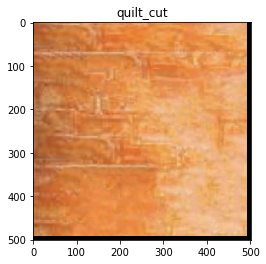

In [15]:
res = quilt_cut(sample_img, 501, 31, 11, 0.00005) 
plt.imshow(res[...,-1::-1]) # overlap 0.005 is not enough while 0.0005 is enough
plt.title('quilt_cut')
plt.show()

### part IV: Texture Transfer (30 pts)

In [16]:
import math
# Suppose I have a template T, a mask M, and an image I: then, 
# ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
def ssd_overlap(sample, patch_size, template, mask):
    """
    ssd_patch performs template matching with the overlapping region, computing the cost of sampling 
    each patch, based on the sum of squared differences (SSD) of the overlapping regions of the existing 
    and sampled patch.
    """
    sample_size = min(sample.shape[0],sample.shape[1])
    start_index = (patch_size-1) // 2 
    end_index = (sample_size-1) - start_index # end index is 191-9=182, take care !!!!!!!!
    ssd = ((mask*template)**2).sum() - 2 * cv2.filter2D(sample, ddepth=-1, kernel = mask*template) + cv2.filter2D(sample ** 2, ddepth=-1, kernel=mask)
#     plt.imshow(ssd.mean(2)) !!!!!!!!!!!
#     plt.show()
    cost_image = np.zeros((sample_size,sample_size), dtype=np.float32) 
    for i in range(start_index,end_index+1):
        for j in range(start_index,end_index+1):
            cost_image[i,j] = ssd[i,j].sum()
#     print("cost image")
#     print(cost_image)
#     plt.imshow(cost_image)
#     plt.show()
    return cost_image

In [17]:
def ssd_transfer(sample, patch_size, target_patch):
    sample_size = min(sample.shape[0],sample.shape[1])
    k = (patch_size-1) // 2 
    start_index = (patch_size-1) // 2 
    end_index = (sample_size-1) - start_index # end index is 191-9=182, take care !!!!!!!!
    cost_image = np.zeros((sample_size,sample_size), dtype=np.float32)
    for i in range(start_index,end_index+1):
        for j in range(start_index,end_index+1):
            cost_image[i,j] = 0
            for m in range (-k,k+1):
                for n in range (-k,k+1):
                    cost_image[i,j] += abs(sample[i+m,j+n]-target_patch[k+m,k+n])
    return cost_image

In [18]:
def choose_sample(sample, patch_size, cost_image, tol):
    sample_size = min(sample.shape[0],sample.shape[1])
    # for sample.shape = (192,192,3) and patch_size = 19 and overlap = 5
    start_index = (patch_size-1) // 2 # start index is (19-1)/2=9
    end_index = (sample_size-1) - start_index  # end index is 191-9=182, take care !!!!!!!!
    minc = float("inf")
    # first to find the min cost 
    for i in range (start_index,end_index+1):
        for j in range (start_index,end_index+1):
            if cost_image[i,j] < minc:
                minc = cost_image[i,j]
    compare_cost = minc*(1+tol)
    for i in range (start_index,end_index+1):
        for j in range (start_index,end_index+1):
            if cost_image[i,j] < compare_cost:
                return i,j

In [19]:
def texture_transfer(sample, target, patch_size, overlap, tol): 
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    target_size = target.shape
    out_size1 = target.shape[0]
    out_size2 = target.shape[1]
    output = np.zeros((out_size1,out_size2), dtype=np.float32)
    patch_size_remained = patch_size - overlap
    number1 = (out_size1 - patch_size) // patch_size_remained + 1 # the number of patches in one row
    number2 = (out_size2 - patch_size) // patch_size_remained + 1 # the number of patches in one column
    # Start by sampling a random patch for the upper-left corner. 
    k = (patch_size-1) // 2
    target_patch_ini = target[0:0+patch_size,0:0+patch_size]
    cost_image_ini = ssd_transfer(sample, patch_size, target_patch_ini)
    a, b = choose_sample(sample, patch_size, cost_image_ini, tol)

    output[0:patch_size,0:patch_size] = sample[a:a+patch_size,b:b+patch_size]
    print(a,b)
    # the second patch along the top row will overlap by patch_size 
    # pixels in the vertical direction and overlap pixels in the horizontal direction.
    for h_left_index in range (0,number1):
        for w_left_index in range (0,number2):
            # The mask has the same size as the patch template and 
            # has values of 1 in the overlapping region and values of 0 elsewhere.
            mask = np.zeros((patch_size,patch_size), dtype=np.float32)
            # the coordinate of the left_top point is (x_left_top*patch_size_remained, y_left_top*patch_size_remained)
            if (w_left_index == 0) and (h_left_index == 0):
                mask[:,0:overlap] = 1.0
                mask[0:overlap,:] = 1.0
                continue
            elif (h_left_index == 0):
                mask[:,0:overlap] = 1.0
            elif (w_left_index == 0):
                mask[0:overlap,:] = 1.0
            else:
                mask[:,0:overlap] = 1.0
                mask[0:overlap,:] = 1.0
            h_left = h_left_index * patch_size_remained
            w_left = w_left_index * patch_size_remained
            #  The template is the patch in the current output image that is to be filled in 
            # (many pixel values will be 0 because they are not filled in yet). 
            template = output[h_left:h_left+patch_size,w_left:w_left+patch_size]
            target_patch = target[h_left:h_left+patch_size,w_left:w_left+patch_size]
            cost_image1 = ssd_overlap(sample, patch_size, template, mask)
            cost_image2 = ssd_transfer(sample, patch_size, target_patch)
            cost_image = cost_image1*0.5 + cost_image2*0.5
            i ,j = choose_sample(sample, patch_size, cost_image, tol)
            # output[h_left:h_left+patch_size,w_left:w_left+patch_size] = sample[i-k:i+k+1, j-k:j+k+1] 
            # the same as the patch_size
            # added code for quilt_cost -----------------------------------------------------------
            # the situdation of left overlaps
            if (h_left_index == 0): 
                overlap_origin = output[h_left:h_left+patch_size,w_left:w_left+overlap] 
                overlap_sample = sample[i-k:i-k+patch_size, j-k:j-k+overlap]
                
                err_patch = calculate_err(overlap_origin,overlap_sample)
                mask = cut(err_patch.T)
                mask = mask.T
                h,w = mask.shape
                mask_handle = np.zeros((h,w), dtype = np.float32)
                # convert int to float, can't find easier way
                for a in range(h):
                    for b in range(w):
                        if mask[a,b] == 1:
                            mask_handle[a,b] = 1.0
                        else:
                            mask_handle[a,b] = 1.0
                overlap_mix = overlap_origin*(1-mask_handle) + overlap_sample*mask_handle
                output[h_left:h_left+patch_size,w_left:w_left+patch_size] = sample[i-k:i+k+1, j-k:j+k+1] 
                output[h_left:h_left+patch_size,w_left:w_left+overlap] = overlap_mix
            # the situdation of top overlaps
            elif (w_left_index == 0): 
                overlap_origin = output[h_left:h_left+overlap,w_left:w_left+patch_size] 
#                 plt.imshow(overlap_origin[...,-1::-1])
#                 plt.show()
                overlap_sample = sample[i-k:i-k+overlap, j-k:j-k+patch_size]
#                 plt.imshow(overlap_sample[...,-1::-1])
#                 plt.show()
                err_patch = calculate_err(overlap_origin,overlap_sample)
#                 print("cost")
#                 plt.imshow(err_patch[...,-1::-1])
#                 plt.show()
                
                mask = cut(err_patch)
                h,w = mask.shape
                mask_handle = np.zeros((h,w), dtype = np.float32)
                # convert int to float, cannot find easier way
                for a in range(h):
                    for b in range(w):
                        if mask[a,b] == 1:
                            mask_handle[a,b] = 1.0
                        else:
                            mask_handle[a,b] = 1.0
#                 temp1 = overlap_origin*(1-mask_handle)
#                 plt.imshow(temp1[...,-1::-1])
#                 plt.show()
#                 temp2 = overlap_sample*mask_handle
#                 plt.imshow(temp2[...,-1::-1])
#                 plt.show()
                overlap_mix = overlap_origin*(1-mask_handle) + overlap_sample*mask_handle
#                 plt.imshow(overlap_mix[...,-1::-1])
#                 plt.show()
                output[h_left:h_left+patch_size,w_left:w_left+patch_size] = sample[i-k:i+k+1, j-k:j+k+1] 
                output[h_left:h_left+overlap,w_left:w_left+patch_size] = overlap_mix
            # if a patch has top and left overlaps, you will need to compute two seams, 
            # and the mask can be defined as the intersection of the masks for each seam (mask1&mask2)
            else:
                # left overlaps part
                overlap_origin = output[h_left:h_left+patch_size,w_left:w_left+overlap] 
                overlap_sample = sample[i-k:i-k+patch_size, j-k:j-k+overlap]
               
                err_patch = calculate_err(overlap_origin,overlap_sample)
                mask3 = cut(err_patch.T)
                mask3 = mask3.T

                h,w = mask3.shape
                mask3_extend = np.ones((patch_size,patch_size), dtype = "int") 
                for a in range(h):
                    for b in range(w):
                        if mask3[a,b] == 1:
                            mask3_extend[a,b] = 1                               
                        else:
                            mask3_extend[a,b] = 0
                
                # top overlaps part
                overlap_origin = output[h_left:h_left+overlap,w_left:w_left+patch_size] 
                overlap_sample = sample[i-k:i-k+overlap, j-k:j-k+patch_size]
                err_patch = calculate_err(overlap_origin,overlap_sample)
                mask4 = cut(err_patch)

                h,w = mask4.shape
                mask4_extend = np.ones((patch_size,patch_size), dtype = "int")
                # convert int to float, cannot find easier way
                for a in range(h):
                    for b in range(w):
                        if mask4[a,b] == 1:
                            mask4_extend[a,b] = 1                               
                        else:
                            mask4_extend[a,b] = 0
                mask_combined = mask3_extend & mask4_extend
                # convert int to float, cannot find easier way, and convert to three dimensions
                mask_combined_handle = np.zeros((patch_size,patch_size), dtype = np.float32)
                for a in range(patch_size):
                    for b in range(patch_size):
                        if mask_combined[a,b] == 1:
                            mask_combined_handle[a,b] = 1.0
                        else:
                            mask_combined_handle[a,b] = 1.0
#                 plt.imshow(mask_combined_handle)
#                 plt.show()
                overlap_mix_extend = (1.0-mask_combined_handle) * template \
                + mask_combined_handle * sample[i-k:i-k+patch_size, j-k:j-k+patch_size] 
                output[h_left:h_left+patch_size,w_left:w_left+patch_size] = overlap_mix_extend
    return output
    


(200, 196)
(355, 271)
(100, 120)
(140, 140)


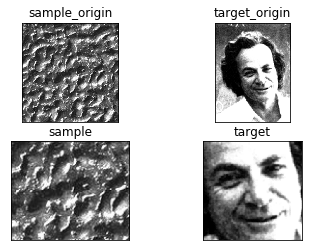

In [20]:
def read_image(image_path):
    intensity_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return intensity_image.astype(np.float32) / 255
sample_file = "./samples/sample1.jpg"
target_file = "./samples/feynman.tiff"
sample = read_image(sample_file)
target = read_image(target_file)
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(sample,cmap='gray')
axes[0,0].set_title('sample_origin'), axes[0,0].set_xticks([]), axes[0,0].set_yticks([])
axes[0,1].imshow(target,cmap='gray')
axes[0,1].set_title('target_origin'), axes[0,1].set_xticks([]), axes[0,1].set_yticks([]);
print(sample.shape)
print(target.shape)
sample = sample[sample.shape[0]//2-50:sample.shape[0]//2+50, sample.shape[1]//2-50:sample.shape[1]//2+70]
target = target[target.shape[0]//2-50:target.shape[0]//2+90, target.shape[1]//2-50:target.shape[1]//2+90]
print(sample.shape)
print(target.shape)

axes[1,0].imshow(sample,cmap='gray')
axes[1,0].set_title('sample'), axes[1,0].set_xticks([]), axes[1,0].set_yticks([])
axes[1,1].imshow(target,cmap='gray')
axes[1,1].set_title('target'), axes[1,1].set_xticks([]), axes[1,1].set_yticks([]);

33 78


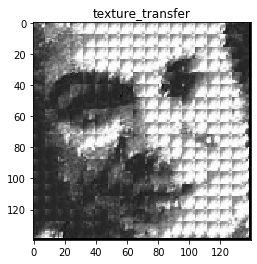

In [21]:
res = texture_transfer(sample, target, 11, 3, 0.0005) 
plt.imshow(res,cmap='gray') 
plt.title('texture_transfer')
plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).